In [2]:
import numpy as np
import pandas as pd
import random

import os
import pickle
import sys
import timeit

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_spd_matrix
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.stats import pearsonr 

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter

from matplotlib.pyplot import imshow
import seaborn as sns

%matplotlib inline 

from IPython.display import Image 

from util import fit_IPTW_LR, fit_IPTW_RF, fit_IPTW_SVM
from util import sim_Data, sim_Unobs_Data, evaluation, bayes_unobs_confounder
import pickle

from util import *

<img src="split_treatment.png" width="400"/>

## Generate data with no-unobs. confounding

In [ ]:
xDim = 50
nSim = 10000

p_AgivenZ = 1
p_AgivenNotZ = 0.1
        
X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)

print('Fit IPTW + LR')
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

print('Fit IPTW + SVM')
Yhat_0, Yhat_1 = fit_IPTW_SVM(X_data, Y_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

## Violation of Assumption 1: Generate data with unobs. confounding

In [ ]:
xDim = 50
nSim = 10000
p_AgivenZ = 1
p_AgivenNotZ = 0.1

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Unobs_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data,A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

## Violation of Assumption 2: Generate data violating the split-treatment criterion 

In [ ]:
xDim = 50
nSim = 10000
p_AgivenZ = 0.6
p_AgivenNotZ = 0.7

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

# Refutation Analysis

### Generating Unobserved Confounders

In [ ]:
# Treatment: A_data; Features: X_data; Labels: Y_data [ Each of shape 10k*1 or 10k*50 ]
# A and A_data are the same

xDim = 50
nSim = 10000

A_matched_Z = []
RMSEs = []
A_matched_Z_unobs = []
RMSEs_unobs = []

corr_t=[]
corr_y=[]
counter=0
for p_AgivenZ in [0.6, 0.7, 0.8, 0.9, 1]:
    for p_AgivenNotZ in [0.5, 0.4, 0.3, 0.2, 0.1]:

        X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
        print(np.sum(Y_0_data), np.sum(Y_1_data))
        
        #Generate Obs Refutation Data
        alpha= 1000
        eps= 10*alpha
        corr_treat, corr_out, X_data_unobs= bayes_unobs_confounder(X_data, A_data, Y_data, alpha, eps)
        corr_t.append(corr_treat)
        corr_y.append(corr_out)
        
        #Results on Normal Data
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
        a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
        
        A_matched_Z.append(a_matched_z)
        RMSEs.append(rmse)
        
        #Results on Confounded Data
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data_unobs, Y_data, A_data, nObs)
        a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
        
        A_matched_Z_unobs.append(a_matched_z)
        RMSEs_unobs.append(rmse)
        
        
#         if counter ==0:
#             counter+=1
#             print(X_data.shape, Y_data.shape, A_data.shape, Group_data.shape, Y_0_data.shape, Y_1_data.shape)
#             print(Y_data[0], Y_0_data[0], Y_1_data[0], A[0])
#             print(Y_data[10], Y_0_data[10], Y_1_data[10], A[10])
#             print(A_data)
#             print(A, Z, nObs, len(A), len(Z))
            
#             if np.array_equal(A, A_data):
#                 print('Yes')
                
#             if np.array_equal(X_data, Group_data):
#                 print('Yes')
#             else:
#                 print('No')

corr_t=np.array(corr_t)
corr_y=np.array(corr_y)

print('Final')
print('Correlation Treatment: ', np.mean(corr_t), np.std(corr_t))
print('Correlation Outcome: ', np.mean(corr_y), np.std(corr_y))

### Results with True Data

In [ ]:
A_matched_Z = np.array(A_matched_Z)
RMSEs = np.array(RMSEs)
sort_indice = np.argsort(A_matched_Z)
plt.plot(A_matched_Z[sort_indice], RMSEs[sort_indice])
plt.xlabel('% of A matched Z')
plt.ylabel('RMSE')

### Results with Unobs Confounding

In [ ]:
A_matched_Z_unobs = np.array(A_matched_Z_unobs)
RMSEs_unobs = np.array(RMSEs_unobs)
sort_indice = np.argsort(A_matched_Z_unobs)
plt.plot(A_matched_Z_unobs[sort_indice], RMSEs_unobs[sort_indice])
plt.xlabel('% of A matched Z')
plt.ylabel('RMSE')

## Placebo Confounder

Avg compliance: 0.5999999999999999
579.0452636634209 831312.3785969967
p_A: 0.4992, IPTW: 1.00 +/- 0.08
Est. Y_0 RMSE: 0.0059191129293713705
Est. Y_1 RMSE: 0.027836103622799323
Debug:  83.05417413035565
80.6% A matched Z, RMSE: 0.15
% of A matched Z 0.8059
Mean recovered rank without Placebo Treatment:  0.15033296378372907 2.4922
(array([0., 1.]), array([4981, 5019]))
p_A: 0.5019, IPTW: 1.00 +/- 0.07
Est. Y_0 RMSE: 0.18942153342168522
Est. Y_1 RMSE: 42.446374976924375
Debug:  40.437536822987255
49.5% A matched Z, RMSE: 1.13
% of A matched Z 0.4946
Mean recovered rank with Placebo Treatment:  1.1271202242884297 2.4922
Avg compliance: 0.5999999999999999
-1292.8762278881181 826873.7904387783
p_A: 0.494, IPTW: 1.00 +/- 0.07


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 0.018949444499713756
Est. Y_1 RMSE: 0.3149653048033724
Debug:  83.51874684084872
79.9% A matched Z, RMSE: 0.20
% of A matched Z 0.7991
Mean recovered rank without Placebo Treatment:  0.19646882704388502 2.4845
(array([0., 1.]), array([4964, 5036]))
p_A: 0.5036, IPTW: 1.00 +/- 0.07


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 14.025177188345097
Est. Y_1 RMSE: 57.401104221939434
Debug:  14.699696458531852
50.0% A matched Z, RMSE: 1.28
% of A matched Z 0.5003
Mean recovered rank with Placebo Treatment:  1.2822636234409834 2.4845


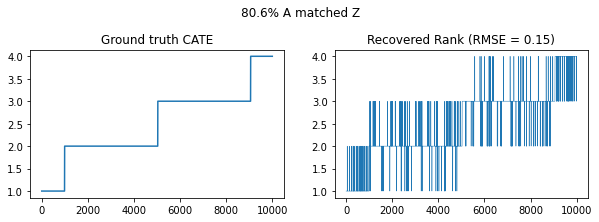

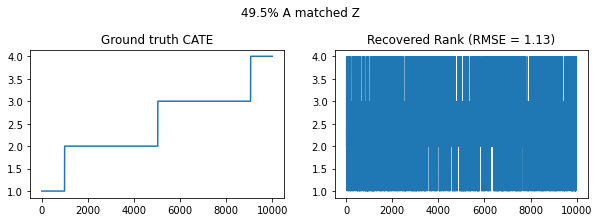

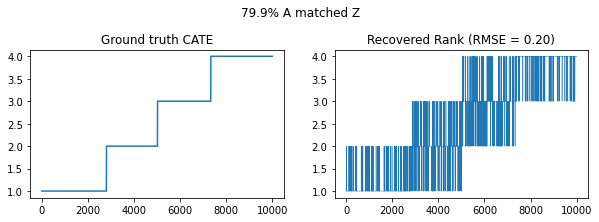

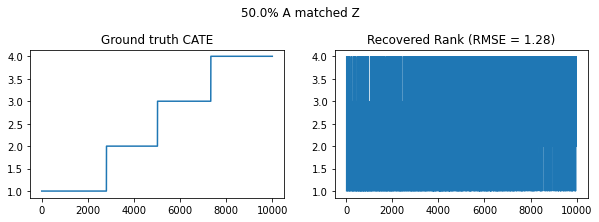

In [3]:
methods=['IPTW_LR', 'IPTW_SVM']

for method in methods:
    xDim = 50
    nSim = 10000

    #Data Generation
    # A percentage Z match 77% params
    p_AgivenZ= 0.8
    p_AgivenNotZ=0.2

    X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
    print(np.sum(Y_0_data), np.sum(Y_1_data))

    # No Confounder
    if method == 'IPTW_LR':
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
    elif method == 'IPTW_SVM':
        Yhat_0, Yhat_1 = fit_IPTW_SVM(X_data, Y_data, A_data, nObs)

    a_matched_z, rmse, recovered_rank = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
    print('% of A matched Z', a_matched_z)
    print('Mean recovered rank without Placebo Treatment: ', rmse, np.mean(recovered_rank))


    #Placebo Confounder
    A_matched_Z_unobs = []
    RMSEs_unobs = []

    A_data_placebo= placebo_confounder(X_data, A_data, Y_data)

    #Results on Confounded Data
    if method == 'IPTW_LR':
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data,  A_data_placebo, nObs)
    elif method == 'IPTW_SVM':
        Yhat_0, Yhat_1 = fit_IPTW_SVM(X_data, Y_data,  A_data_placebo, nObs)

    a_matched_z, rmse, recovered_rank = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A_data_placebo, Z)
    print('% of A matched Z', a_matched_z)
    print('Mean recovered rank with Placebo Treatment: ', rmse, np.mean(recovered_rank))

## Sweep over Unobs Confounders

Avg compliance: 0.5999999999999999
2659.250071493571 836159.2500714934
p_A: 0.4964, IPTW: 1.00 +/- 0.08
Est. Y_0 RMSE: 0.008543153916571438
Est. Y_1 RMSE: 0.053068924132153805
Debug:  83.28838792195127
80.4% A matched Z, RMSE: 0.14
% of A matched Z 0.8038
Alpha:  1000  Sample_size :  5036  Sum_  0.46644630707014306 2349.0236024052406 0.664884574628795
Alpha:  1000  Sample_size :  4964  Sum_  83.39582859302074 413976.893135755 83.58064312905437


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4964, IPTW: 1.00 +/- 0.83
Est. Y_0 RMSE: 0.0007173617451087083
Est. Y_1 RMSE: 0.029477546311869343
Debug:  83.31980509194301
80.4% A matched Z, RMSE: 0.17
Final
Correlation Treatment:  0.5046824058268709
Correlation Outcome:  0.44829432202722796
[3. 3. 2. ... 3. 1. 2.]
Alpha:  5000  Sample_size :  5036  Sum_  0.46644630707014306 2349.0236024052406 1.4590080608308995
Alpha:  5000  Sample_size :  4964  Sum_  83.39582859302074 413976.893135755 84.3862826053887
p_A: 0.4964, IPTW: 1.00 +/- 0.86
Est. Y_0 RMSE: 0.006738341884056092
Est. Y_1 RMSE: 0.04422606765139076
Debug:  83.29903559046454
80.4% A matched Z, RMSE: 0.17
Final
Correlation Treatment:  0.4955728600166223
Correlation Outcome:  0.4417488396052117
[3. 3. 2. ... 3. 1. 2.]
Alpha:  10000  Sample_size :  5036  Sum_  0.46644630707014306 2349.0236024052406 2.4516624185835303
Alpha:  10000  Sample_size :  4964  Sum_  83.39582859302074 413976.893135755 85.39333195080663


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4964, IPTW: 1.00 +/- 0.52
Est. Y_0 RMSE: 0.006084922154317056
Est. Y_1 RMSE: 0.14863876672008897
Debug:  83.20744615543421
80.4% A matched Z, RMSE: 0.15
Final
Correlation Treatment:  0.38763453260312397
Correlation Outcome:  0.3455994597417558
[3. 3. 2. ... 3. 1. 2.]
Alpha:  50000  Sample_size :  5036  Sum_  0.46644630707014306 2349.0236024052406 10.392897280604574
Alpha:  50000  Sample_size :  4964  Sum_  83.39582859302074 413976.893135755 93.44972671415003


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4964, IPTW: 1.00 +/- 0.21
Est. Y_0 RMSE: 0.011213507044798413
Est. Y_1 RMSE: 0.015229344759053697
Debug:  83.32355714819613
80.4% A matched Z, RMSE: 0.14
Final
Correlation Treatment:  0.1785567877634816
Correlation Outcome:  0.15847465292195456
[3. 3. 2. ... 3. 1. 2.]
Alpha:  100000  Sample_size :  5036  Sum_  0.46644630707014306 2349.0236024052406 20.31944085813088
Alpha:  100000  Sample_size :  4964  Sum_  83.39582859302074 413976.893135755 103.52022016832929


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4964, IPTW: 1.00 +/- 0.15
Est. Y_0 RMSE: 0.008178477477279443
Est. Y_1 RMSE: 0.03531934275563058
Debug:  83.30650217976708
80.4% A matched Z, RMSE: 0.14
Final
Correlation Treatment:  0.12146043373075824
Correlation Outcome:  0.10825448438546013
[3. 3. 2. ... 3. 1. 2.]
[4 3 2 1 0] [0.16792856 0.17262677 0.15297059 0.13711309 0.14071247]
Avg compliance: 0.5999999999999999
318.100952450708 836051.4342857839
p_A: 0.4979, IPTW: 1.00 +/- 0.08


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 0.03388295073369807
Est. Y_1 RMSE: 0.1966785805319637
Debug:  83.87102973748914
79.6% A matched Z, RMSE: 0.17
% of A matched Z 0.7963
Alpha:  1000  Sample_size :  5021  Sum_  0.2116172813821074 1062.5303698195612 0.4106989983710795
Alpha:  1000  Sample_size :  4979  Sum_  83.6424122479677 416455.57058263116 83.82662059892192


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4979, IPTW: 1.00 +/- 0.91


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 2.7034809127898844
Est. Y_1 RMSE: 13.343783814740021
Debug:  68.82161294042338
79.6% A matched Z, RMSE: 0.81
Final
Correlation Treatment:  0.49841221300066796
Correlation Outcome:  0.4270353221682769
[1. 1. 3. ... 3. 2. 3.]
Alpha:  5000  Sample_size :  5021  Sum_  0.2116172813821074 1062.5303698195612 1.2071944185224137
Alpha:  5000  Sample_size :  4979  Sum_  83.6424122479677 416455.57058263116 84.62983345032754


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4979, IPTW: 1.00 +/- 0.88


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 1.8317910913440711
Est. Y_1 RMSE: 1.6326893068457666
Debug:  83.83006765214131
79.6% A matched Z, RMSE: 0.31
Final
Correlation Treatment:  0.515342993672643
Correlation Outcome:  0.4372327617559093
[2. 1. 3. ... 4. 2. 4.]
Alpha:  10000  Sample_size :  5021  Sum_  0.2116172813821074 1062.5303698195612 2.202813693711581
Alpha:  10000  Sample_size :  4979  Sum_  83.6424122479677 416455.57058263116 85.63384951458457
p_A: 0.4979, IPTW: 1.00 +/- 0.52


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 4.961971038045781
Est. Y_1 RMSE: 3.9741095497093686
Debug:  74.90225847596739
79.6% A matched Z, RMSE: 0.50
Final
Correlation Treatment:  0.3872015336211062
Correlation Outcome:  0.32831948952741413
[3. 1. 3. ... 3. 2. 4.]
Alpha:  50000  Sample_size :  5021  Sum_  0.2116172813821074 1062.5303698195612 10.167767895224923
Alpha:  50000  Sample_size :  4979  Sum_  83.6424122479677 416455.57058263116 93.6659780286408


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4979, IPTW: 1.00 +/- 0.22


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 29.2514705136237
Est. Y_1 RMSE: 31.32542692364528
Debug:  34.972069398565864
79.6% A matched Z, RMSE: 0.75
Final
Correlation Treatment:  0.1951911604549406
Correlation Outcome:  0.16113566405472354
[2. 3. 2. ... 4. 2. 4.]
Alpha:  100000  Sample_size :  5021  Sum_  0.2116172813821074 1062.5303698195612 20.1239606471166
Alpha:  100000  Sample_size :  4979  Sum_  83.6424122479677 416455.57058263116 103.70613867121108


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4979, IPTW: 1.00 +/- 0.15


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 33.84087048641882
Est. Y_1 RMSE: 34.76034993065763
Debug:  30.575567643224215
79.6% A matched Z, RMSE: 0.75
Final
Correlation Treatment:  0.12530593611423835
Correlation Outcome:  0.1018056184010255
[2. 1. 3. ... 3. 3. 2.]
[4 3 2 1 0] [0.8096913  0.31272992 0.50199602 0.75206383 0.75153177]


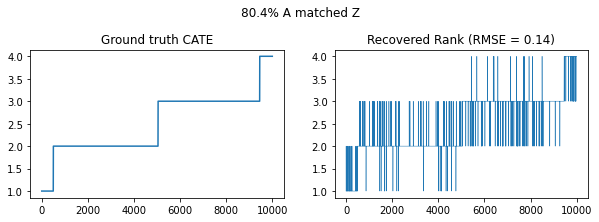

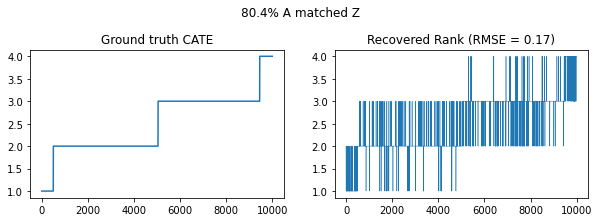

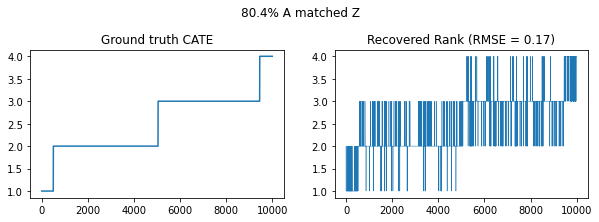

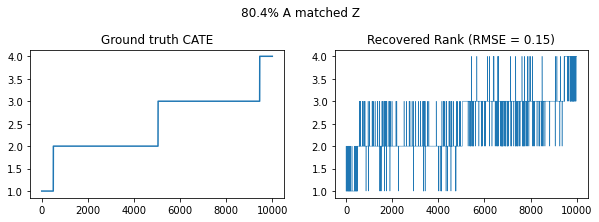

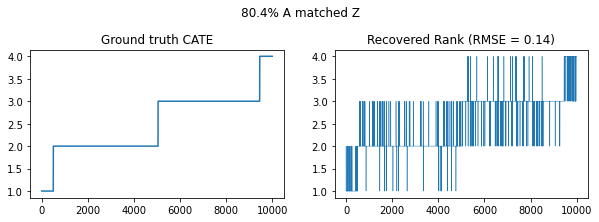

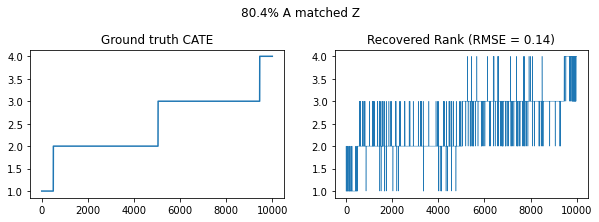

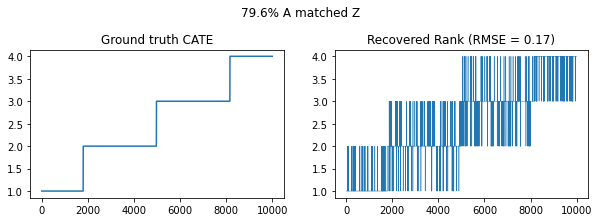

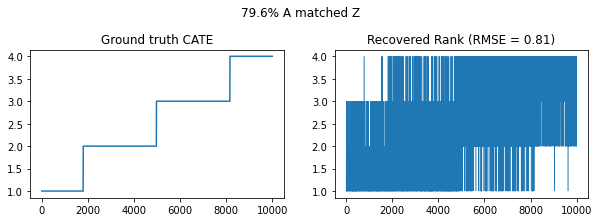

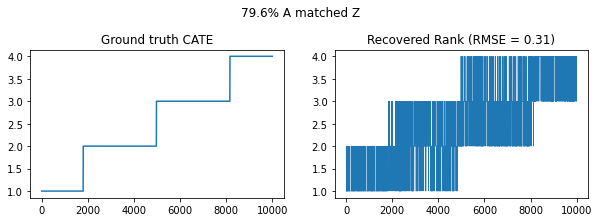

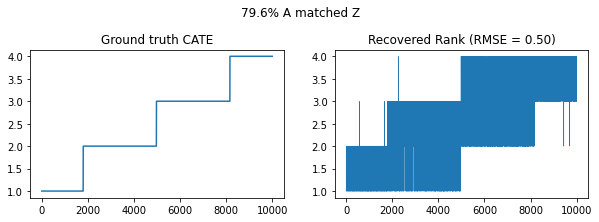

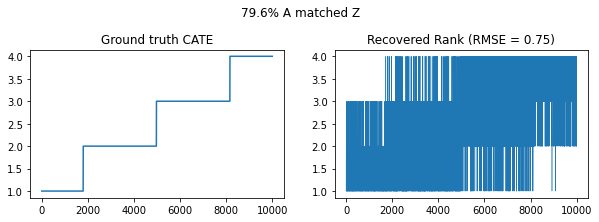

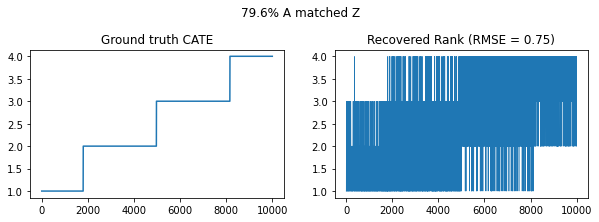

In [4]:
methods=['IPTW_LR', 'IPTW_SVM']
res=[]
res_refute=[]
for method in methods:

    alpha_range, sort_indice, a_matched_z, A_matched_Z_unobs, RMSEs_refute, RMSEs_unobs, RMSEs, corr_t, corr_y= refutation_analysis(method)

    A_matched_Z_unobs = np.array(A_matched_Z_unobs)
    RMSEs_unobs = np.array(RMSEs_unobs)

    sort_indice = np.argsort(A_matched_Z_unobs)
    sort_indice = sort_indice[::-1]
    
    res.append(RMSEs_unobs)
    res_refute.append(RMSEs_refute)

## Bar Plot

### RMSE with ground truth data

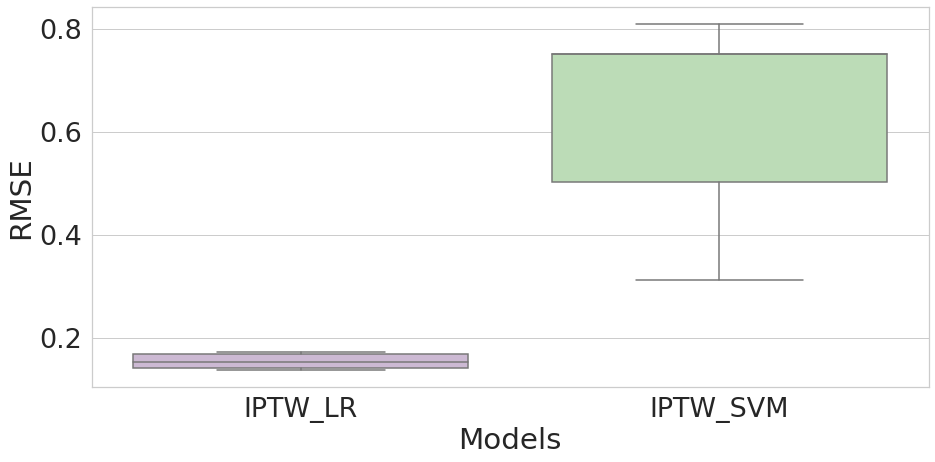

In [5]:
plot_df= pd.DataFrame(columns=methods)
for idx in range(len(methods)):
    plot_df[methods[idx]]= res[idx]

sns.set(font_scale=2.45)
sns.set_style("whitegrid")
#sns.set(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

fig, ax1 = plt.subplots(figsize = [15,7])

fig = sns.boxplot(data = plot_df, palette='PRGn')
fig.set_xlabel('Models')
fig.set_ylabel('RMSE')
plt.savefig('images/sensitivity_analysis_synthetic.png', dpi=200)

### RMSE with no confounder data

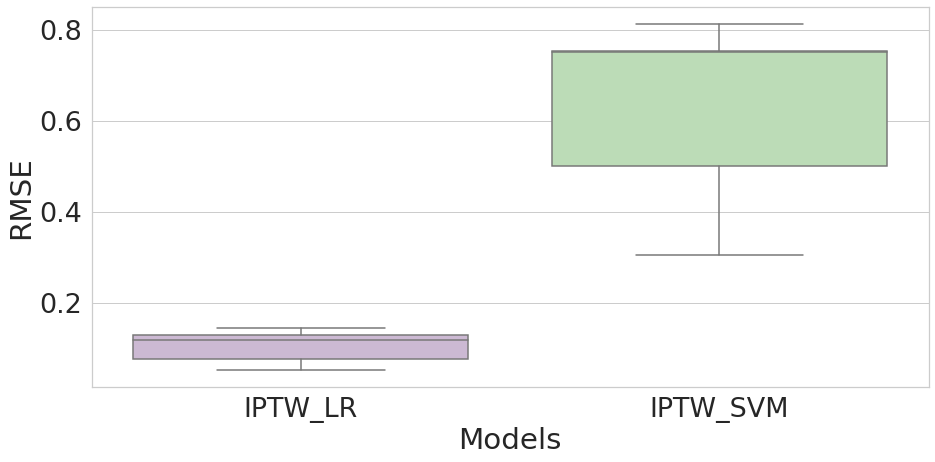

In [6]:
plot_df= pd.DataFrame(columns=methods)
for idx in range(len(methods)):
    plot_df[methods[idx]]= res_refute[idx]

sns.set(font_scale=2.45)
sns.set_style("whitegrid")
#sns.set(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

fig, ax1 = plt.subplots(figsize = [15,7])

fig = sns.boxplot(data = plot_df, palette='PRGn')
fig.set_xlabel('Models')
fig.set_ylabel('RMSE')
plt.savefig('images/sensitivity_analysis_synthetic.png', dpi=200)

## Line Plots

In [ ]:
plt.plot(alpha_range[sort_indice], RMSEs_unobs[sort_indice], '-ok', label='Confounder-SVM')
plt.plot(alpha_range[sort_indice], len(alpha_range)*RMSEs, label='No Confounder-SVM')
plt.xlabel('Confounder Strength (10^4/alpha)')
plt.ylabel('RMSE')
plt.title('Refutation analysis with % of A matched Z ' + str(np.round(a_matched_z,2)))
plt.legend()
plt.savefig('images/lr.jpg')

In [ ]:
plt.plot(alpha_range, corr_t, '-ok')
plt.xlabel('Confounder Strength (10^4/alpha)')
plt.ylabel('Pearson Correlation')
plt.title('Correlation of Confounder with Treatment A')
#plt.savefig('images/b_52.jpg')

In [ ]:
plt.plot(alpha_range, corr_y, '-ok')
plt.xlabel('Confounder Strength (10^4/alpha)')
plt.ylabel('Pearson Correlation')
plt.title('Correlation of Confounder with Outcome Y')
#plt.savefig('images/c_52.jpg')